# Business Intelligence 2 Project - GPS Data - Model Building

**Authors:** Brandl Moritz & Miklautz Lukas

Feel free to checkout our project on [github](https://github.com/MoBran/bi2_project)


**Short Summary:**

In this notebook, we perform feature engineering for our model, in which we want to predict wether a traffic jam on a specific route is likely or not in the city of Aracaju in Brazil. The data consists of GPS tracking data gathered in the city Aracaju in Brazil. The data set includes two tables. The **go_track_tracks.csv** and the **go_track_trackspoints.csv**. The first one, from here on referred to as tracks data set, contains general information about each recorded trip, like average speed, distance, traffic rating, rating of bus etc. The second table, called trackspoints, contains the GPS data for each trip and the time intervals. 

**Findings:**

We found during data exploration that there are several problems in regard of data quality:
- 17 % of the data are either 0 or duplicate values.
- Time lags in the recorded data between 5 and 20 minutes
- Inconsistent records e.g. some users went by car and submitted a bus rating
- Large discrepancy between travel time per track_id stated in the tracks data table and the one calculated from the trackspoints data table up to 25 minutes. 
- More than 80 % of the data was generated by 8 users out of 28

During the feature engineering process we used the data from tracks table ended up using the following features:
- distance: standardized distance of the track 
- car_or_bus:  Binary variable indicating whether the car == 1 was used or the bus == 0
- month_sinus: Month 0-11 transformed to fit on the unit circle
- month_cosinus: Month 0-11 transformed to fit on the unit circle
- weekday_sinus: Weekday 0-6 transformed to fit on the unit circle
- weekday_cosinus: Weekday 0-6 transformed to fit on the unit circle
- daytime_start_sinus: Hour of the day when the trip started 0-23 transformed to fit on the unit circle
- daytime_start_cosinus: Hour of the day when the trip started 0-23 transformed to fit on the unit circle

For the trackspoints data table we identified the following features:
- quantiles per latitude and longitude
- latitude and longitude per time interval

## Initial State of the Data Table before preprocessing 

### Tracks Data Table - a list of trajectories  
- id_android - it represents the device used to capture the instance;  
- speed - it represents the average speed (Km/H)  
- time - it represents the time in hours
- distance - it represent the total distance (Km)  
- rating - it is an evaluation parameter. Evaluation the traffic is a way to verify the volunteers 
  perception about the traffic during the travel, in other words,  
  if volunteers move to some place and face traffic jam, maybe they will    evaluate 'bad'. (3-good, 2-normal, 1-bad).  
- rating_bus - it is other evaluation parameter. (1 - The amount of people inside the bus is little, 2 - The bus is not crowded, 3- The bus is crowded.  
- rating_weather - it is another evaluation parameter. ( 2- sunny, 1- raining).  
- car_or_bus - (1 - car, 2-bus)  
- linha - information about the bus that does the pathway  

### Trackspoints Data Table -  localization points of each trajectory  
- id: unique key to identify each point  
- latitude: latitude from where the point is  
- longitude: longitude from where the point is  
- track_id: identify the trajectory which the point belong  
- time: datetime when the point was collected (GMT-3) 

In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import datetime as dt
#Visualisation Libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import seaborn as sns


# Self written packages
from data.make_data import DataSet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print("Start reading data:")
parentdir = os.path.dirname(os.getcwd())
datadir = os.path.join(parentdir, "data", "preprocessed")
dataset = DataSet(datadir,file_ending=".csv")
tracks, trackspoints = dataset.get_data()
trackspoints = dataset._preprocess_trackspoint_data(trackspoints)

Start reading data:


Tracks data set

In [29]:
print("Number of data records: ", len(tracks))

tracks.head(10)

Number of data records:  129


,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
0,1,0,19.210586,8.27,2.652,3,0,0,no_answer,1
1,2,0,30.848229,10.22,5.290,3,0,0,no_answer,1
2,3,1,13.560101,3.90,0.918,3,0,0,no_answer,0
3,4,1,19.766679,27.18,7.700,3,0,0,no_answer,0
4,8,0,25.807401,1.73,3.995,2,0,0,no_answer,1
5,10,2,1.346913,0.17,0.009,2,0,0,no_answer,1
6,11,3,36.850787,13.47,8.402,3,0,0,no_answer,1
7,12,1,17.405131,2.30,0.675,3,0,0,no_answer,0
8,13,1,15.395436,31.52,8.111,3,0,0,no_answer,0
9,16,3,15.041348,13.05,3.277,3,0,0,no_answer,1


The table shows a the table head after we applied data preprocessing

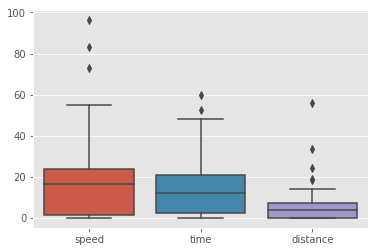

In [4]:
sns.boxplot(data=tracks[['speed','time','distance']]);

The boxplots for the three continuous variables giev an insight about their value distributions. 

Trackspoints data set

In [5]:
print("Number of data records: ", len(trackspoints))
trackspoints.iloc[0:10]

Number of data records:  14206


,id,latitude,longitude,track_id,time
0,1,-10.939341,-37.062742,1,2014-09-13 07:24:32
1,2,-10.939341,-37.062742,1,2014-09-13 07:24:37
2,3,-10.939324,-37.062765,1,2014-09-13 07:24:42
3,4,-10.939211,-37.062843,1,2014-09-13 07:24:47
4,5,-10.938939,-37.062879,1,2014-09-13 07:24:53
5,6,-10.938544,-37.062839,1,2014-09-13 07:24:59
6,7,-10.938346,-37.062588,1,2014-09-13 07:25:04
7,8,-10.938448,-37.062000,1,2014-09-13 07:25:10
8,9,-10.938666,-37.061499,1,2014-09-13 07:25:15
9,10,-10.938986,-37.060819,1,2014-09-13 07:25:21


Head of trackspoints data table after preprocessing

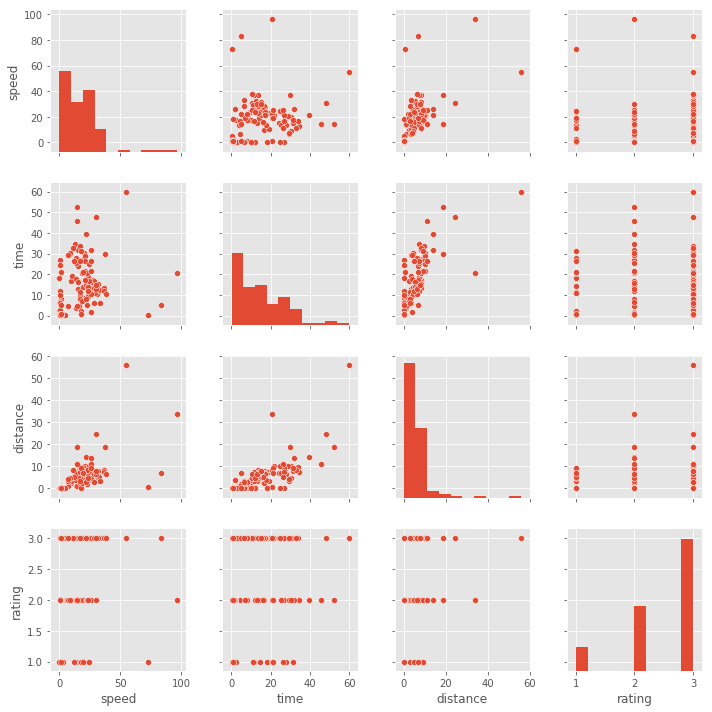

In [6]:
tracks_cor = tracks[['speed','time','distance','rating']]

sns.pairplot(tracks_cor)
plt.tight_layout()
plt.show();

The correlation plot shows some relations between the three continous variables. These relations are logical as speed = distance/time

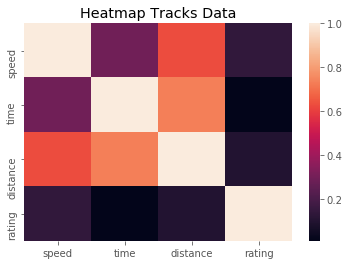

In [7]:
# Calculate correlations
corr = tracks[['speed','time','distance','rating']].corr()
# Heatmap
heatmap = sns.heatmap(corr);
heatmap.set_title("Heatmap Tracks Data");

Different visualization for the correlation between the variables. the best correlation seems to be between distance and time.

**Observe the outliers:**

Outliers for speed > 50 $\frac{km}{h}$

In [8]:
tracks[tracks["speed"]>50]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
31,51,2,72.926755,0.37,0.661,1,0,0,no_answer,0
33,55,1,83.328135,4.98,6.976,3,0,0,no_answer,1
34,58,6,96.206029,20.68,33.739,2,0,0,no_answer,0


Outliers for time > 40 minutes

In [9]:
tracks[tracks["time"]>40]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
83,37962,12,14.712053,52.42,18.819,2,0,0,carro,1
98,38002,12,30.397045,47.93,24.461,3,0,0,carro,1
104,38017,16,14.630896,45.80,11.218,2,0,0,carro,1


Outliers for distance > 20 km

In [10]:
tracks[tracks["distance"]>20]

,id,id_android,speed,time,distance,rating,rating_bus,rating_weather,linha,car_or_bus
16,30,3,54.995947,59.67,55.770,3,0,0,no_answer,1
34,58,6,96.206029,20.68,33.739,2,0,0,no_answer,0
98,38002,12,30.397045,47.93,24.461,3,0,0,carro,1


**We have an unbalanced data set**

In [11]:
for rating in range(1,4):
    nr_of_rated_tracks = len(tracks[tracks["rating"]==rating])
    percentage = round(nr_of_rated_tracks/len(tracks) * 100)
    print("Number tracks with rating {}: {} thats {}% of observations".format(rating, nr_of_rated_tracks,
                                                                              percentage))

Number tracks with rating 1: 14 thats 11% of observations
Number tracks with rating 2: 38 thats 29% of observations
Number tracks with rating 3: 77 thats 60% of observations


There are much more observations with rating 3, than of the others, where rating is the subjective user rating of the traffic and 3=good, 2=normal, 1=bad.

----
## Feature Engineering

Construct weekday and daytime features by mapping the features to the unit circle. This captures the cyclicle nature of the weekday, hours and months variable. The idea is from a blog post on [kdnuggets](https://www.kdnuggets.com/2017/10/top-errors-novice-machine-learning-engineers.html?utm_content=buffer4acd4&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer)


In [12]:
from features.make_features import apply_feature_engineering

feature_engineered_tracks = apply_feature_engineering(tracks, trackspoints, keep_ids=True)

In [13]:
feature_engineered_tracks.head()

,id,id_android,speed,time,distance,rating,car_or_bus,month_sinus,month_cosinus,weekday_sinus,weekday_cosinus,daytime_start_sinus,daytime_start_cosinus,daytime_end_sinus,daytime_end_cosinus
0,1,0,0.178463,-0.466230,-0.347570,3,1,-0.866025,-0.5,-0.974928,-0.222521,0.933580,-0.358368,0.920508,-0.390723
1,2,0,0.921676,-0.309100,0.040259,3,1,-0.866025,-0.5,-0.974928,-0.222521,-0.410727,-0.911758,-0.453990,-0.891007
2,3,1,-0.182393,-0.818363,-0.602497,3,0,-0.866025,-0.5,0.974928,-0.222521,0.975342,0.220697,0.979047,0.203633
3,4,1,0.213977,1.057528,0.394568,3,0,-0.866025,-0.5,0.974928,-0.222521,0.975342,0.220697,0.994522,0.104528
4,8,0,0.599754,-0.993220,-0.150128,2,1,-0.866025,-0.5,-0.433884,-0.900969,-0.782603,-0.622521,-0.788016,-0.615655


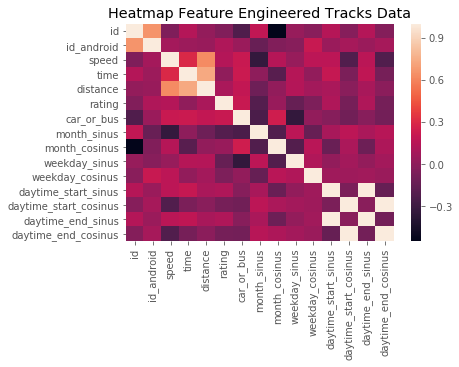

In [14]:
# Calculate correlations
corr = feature_engineered_tracks.corr()
# Heatmap
heatmap = sns.heatmap(corr);
heatmap.set_title("Heatmap Feature Engineered Tracks Data");

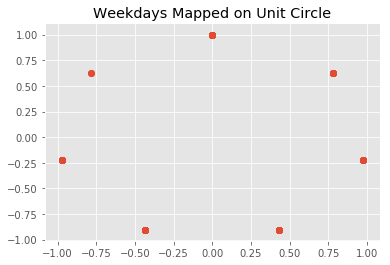

In [15]:
plt.title("Weekdays Mapped on Unit Circle")
plt.scatter(feature_engineered_tracks["weekday_sinus"],
            feature_engineered_tracks["weekday_cosinus"]);


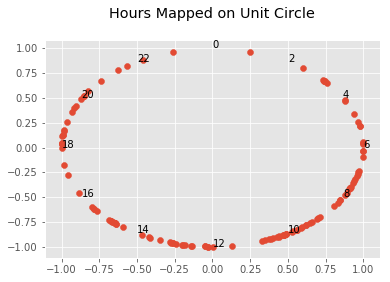

In [16]:
from features.make_features import map_to_sinus
from features.make_features import map_to_cosinus

fig, ax = plt.subplots()
ax.set_title("Hours Mapped on Unit Circle\n")

sinus_mapping = map_to_sinus(pd.DataFrame(np.arange(0,24),columns=["hours"]),"hours")
cosinus_mapping = map_to_cosinus(pd.DataFrame(np.arange(0,24),columns=["hours"]),"hours")

for i in range(0,24,2):
    ax.annotate(str(i),(sinus_mapping[i], cosinus_mapping[i]),
                xytext=(sinus_mapping[i], cosinus_mapping[i]))

ax.scatter(feature_engineered_tracks["daytime_start_sinus"],
           feature_engineered_tracks["daytime_start_cosinus"]);


**Calculate distribution of trips per year**

In [17]:
from utils.general_utils import get_starting_and_end_time_per_trip
starting_times_per_trip, _ = get_starting_and_end_time_per_trip(trackspoints)
print("Number of Trips 2014: ",len(starting_times_per_trip.set_index("trip_start")["2014"]))
print("Number of Trips 2015: ",len(starting_times_per_trip.set_index("trip_start")["2015"]))     
print("Number of Trips 2016: ",len(starting_times_per_trip.set_index("trip_start")["2016"])) 

Number of Trips 2014:  34
Number of Trips 2015:  93
Number of Trips 2016:  2


**Ratings per month**

In [18]:
from utils.general_utils import calculate_ratings_per_time_unit
ratings_per_month = calculate_ratings_per_time_unit(starting_times_per_trip["trip_start"],
                                      feature_engineered_tracks,
                                      time_unit="month")
ratings_per_month

,rating_1,rating_2,rating_3
time,,,
0,0,1,2
1,0,12,10
2,2,1,2
3,1,3,7
4,5,5,17
5,4,3,3
6,0,0,1
7,0,0,3
8,0,2,7


This table shows the ratings for every month of a year. we can see that in july only one rating was recorded while in may 37 were recorded.

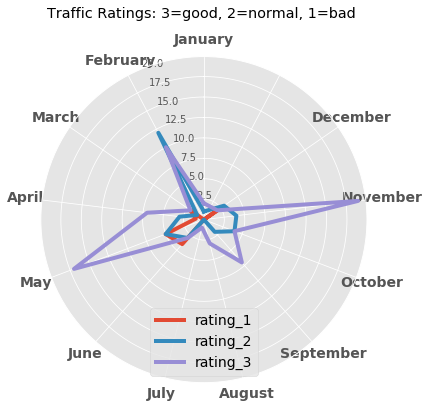

In [19]:
from visualization.visualize import plot_months_polar
plot_months_polar(ratings_per_month)

visualization of the ratings per month data.

**Ratings per weekday**

In [20]:
ratings_per_weekday = calculate_ratings_per_time_unit(starting_times_per_trip["trip_start"],
                                      feature_engineered_tracks,
                                      time_unit="weekday")
ratings_per_weekday

,rating_1,rating_2,rating_3
time,,,
0,3,6,10
1,1,4,11
2,7,3,7
3,1,6,16
4,1,11,16
5,1,6,13
6,0,2,4


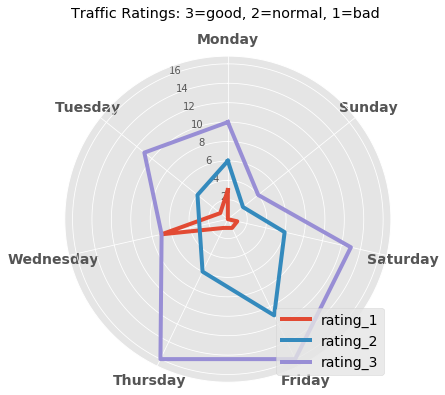

In [21]:
from visualization.visualize import plot_weekdays_polar
plot_weekdays_polar(ratings_per_weekday)

Visualization of ratings per weekday. Few trips were recorded on sundays.

**Ratings per hour of the day**

In [22]:
from visualization.visualize import plot_daytime_polar
ratings_per_daytime = calculate_ratings_per_time_unit(starting_times_per_trip["trip_start"],
                                      feature_engineered_tracks,
                                      time_unit="daytime")
ratings_per_daytime

,rating_1,rating_2,rating_3
time,,,
0,0,0,1
2,0,0,1
3,0,1,4
4,1,2,0
5,0,2,4
6,1,0,4
7,0,4,9
8,0,3,2
9,1,3,8


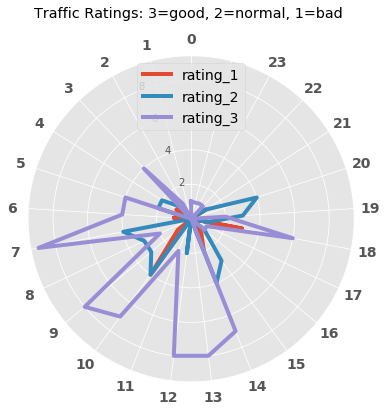

In [23]:
plot_daytime_polar(ratings_per_daytime)

Ratings per hour show that most tracks were collected in the morning or around noon.

----
### Apply feature engineering to trackspoints data

**Time Intervals per track**

Resample the trackspoints data set to new time intervals in minutes and summarize missing values with its nearest neighbour. This results in a sparse matrix, due to many zero values as the table is fitted to its longest trips.

In [24]:
from features.make_features import transform_trackspoints_to_track_per_time_interval

time_interval = 10
longest_trip_duration = 70
trackspoint_per_time = transform_trackspoints_to_track_per_time_interval(trackspoints,feature_engineered_tracks,
                                                                         time_interval,longest_trip_duration)
trackspoint_per_time.head(10)

,latitude_time_0,longitude_time_0,latitude_time_10,longitude_time_10,latitude_time_20,longitude_time_20,latitude_time_30,longitude_time_30,latitude_time_40,longitude_time_40,latitude_time_50,longitude_time_50,latitude_time_60,longitude_time_60,latitude_time_70,longitude_time_70,rating
track_id,,,,,,,,,,,,,,,,,
1,-10.939341,-37.062742,-10.947085,-37.045783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
2,-10.939439,-37.062428,-10.967642,-37.065284,-10.974962,-37.067889,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
3,-10.903162,-37.048294,-10.908875,-37.050502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
4,-10.908893,-37.052372,-10.918437,-37.054132,-10.918545,-37.065355,-10.922517,-37.094919,-10.924209,-37.104686,0.0,0.0,0.0,0.0,0.0,0.0,3
8,-10.943777,-37.052344,-10.946398,-37.051112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2
10,-10.934852,-37.114376,-10.934906,-37.114360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2
11,-10.904516,-37.060768,-10.910336,-37.066997,-10.907717,-37.073212,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
12,-10.905420,-37.048194,-10.908851,-37.051206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3
13,-10.908859,-37.052239,-10.918329,-37.047899,-10.918581,-37.064142,-10.920134,-37.088294,-10.923761,-37.105065,0.0,0.0,0.0,0.0,0.0,0.0,3


**Time Intervals per quantile**

Split the trackspoints data set to a predefined number of quantiles and get each quantile point. This results in a dense representation and is independent of the length of a track.

In [25]:
# Only get quantiles of each trackspoints track to reduce dimensionality
from features.make_features import transform_trackspoints_to_track_per_quantile
number_of_quantiles = 5
trackspoint_per_quantile = transform_trackspoints_to_track_per_quantile(trackspoints, 
                                                                    feature_engineered_tracks,
                                                                    number_of_quantiles)


trackspoint_per_quantile.head(10)


,latitude_quantile_0,longitude_quantile_0,latitude_quantile_1,longitude_quantile_1,latitude_quantile_2,longitude_quantile_2,latitude_quantile_3,longitude_quantile_3,latitude_quantile_4,longitude_quantile_4,latitude_quantile_5,longitude_quantile_5,rating
track_id,,,,,,,,,,,,,
1,-10.939341,-37.062742,-10.941480,-37.057391,-10.943493,-37.053991,-10.941697,-37.050703,-10.943628,-37.047384,-10.947085,-37.045783,3
2,-10.939439,-37.062428,-10.942347,-37.060746,-10.951946,-37.067390,-10.967642,-37.065284,-10.972867,-37.067999,-10.974962,-37.067889,3
3,-10.903162,-37.048294,-10.906654,-37.048235,-10.907750,-37.048128,-10.908886,-37.049570,-10.908896,-37.049712,-10.908875,-37.050502,3
4,-10.908893,-37.052372,-10.918509,-37.054464,-10.918610,-37.063985,-10.918258,-37.073651,-10.919022,-37.085492,-10.924209,-37.104686,3
8,-10.943777,-37.052344,-10.943801,-37.052437,-10.943910,-37.052775,-10.943886,-37.052722,-10.944145,-37.051851,-10.946398,-37.051112,2
10,-10.934852,-37.114376,-10.934852,-37.114376,-10.934852,-37.114376,-10.934920,-37.114357,-10.934920,-37.114357,-10.934906,-37.114360,2
11,-10.904516,-37.060768,-10.910378,-37.064796,-10.910245,-37.068060,-10.907864,-37.073064,-10.907687,-37.073156,-10.907717,-37.073212,3
12,-10.905420,-37.048194,-10.907827,-37.048099,-10.908095,-37.048102,-10.908211,-37.048101,-10.908799,-37.048991,-10.908851,-37.051206,3
13,-10.908859,-37.052239,-10.914953,-37.048372,-10.918435,-37.054285,-10.918636,-37.065572,-10.918313,-37.075187,-10.923761,-37.105065,3


**Evaluate Discriminative Power of Features with Density Plots**

In order to use the model in real live situation where e.g. a user wants to know if a specific route is prone to traffic congestions, we are gonna drop the following features:
- speed = Average Speed on trip
- time = Duration of Trip
- Daytime_End = Hour of day at the end of trip

The remaining features will now be checked for their discriminative power in relation to the ratings.

In [26]:
random_state = 1
drop_columns = ["time","speed","daytime_end_sinus",
                "daytime_end_cosinus"]
features = feature_engineered_tracks.drop(drop_columns,axis=1)
print("Remaining Features: \n", [feature for feature in features.drop("rating",axis=1).columns.values])

Remaining Features: 
 ['id', 'id_android', 'distance', 'car_or_bus', 'month_sinus', 'month_cosinus', 'weekday_sinus', 'weekday_cosinus', 'daytime_start_sinus', 'daytime_start_cosinus']


The density plots below show the distributions for every rating in every selected variable. by looking at the densities we can identify distinc features if the densities do not overlap. Unfortunately for np feature this is the case. the data for every rating seem too similar to distinguish with their distributions.

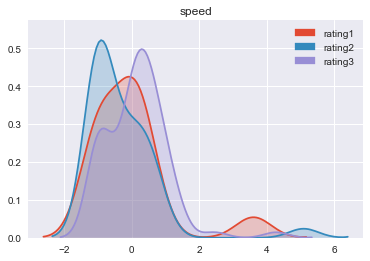

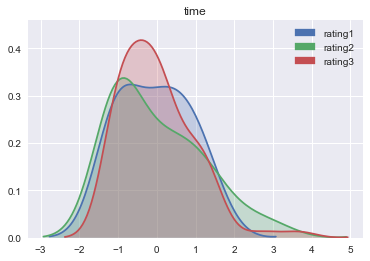

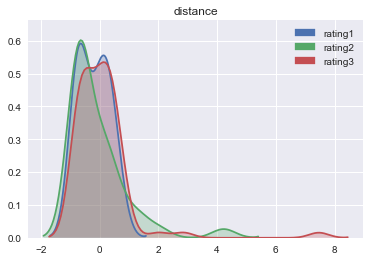

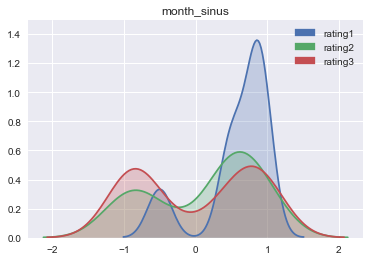

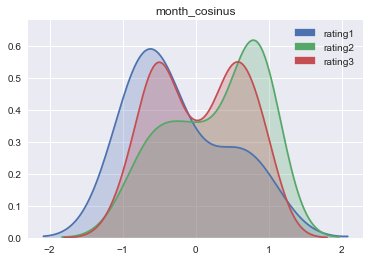

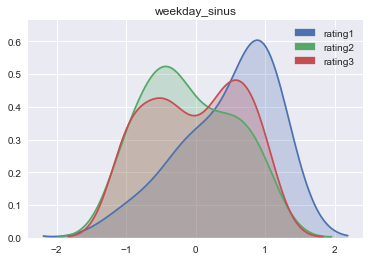

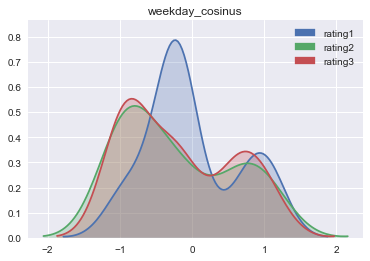

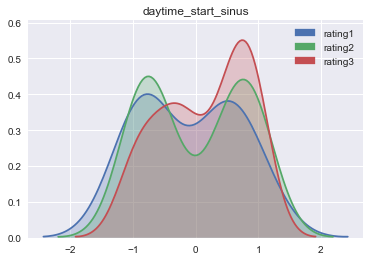

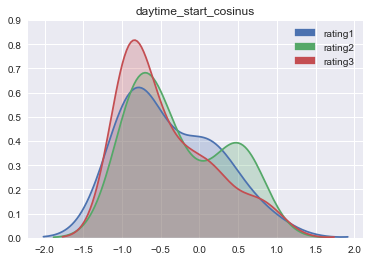

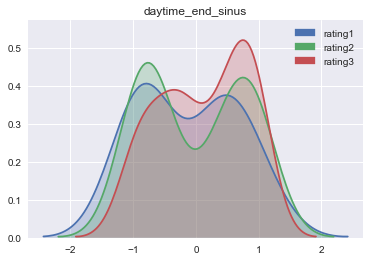

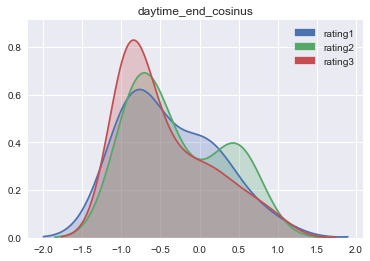

In [27]:
from visualization.visualize import create_density_plot_for_categorical_variable

features = list(feature_engineered_tracks.drop(["car_or_bus", "rating", "id", "id_android"], axis = 1).columns.values)

for feature in features:
    create_density_plot_for_categorical_variable(feature_engineered_tracks, feature, "rating")

In [30]:
os.path.relpath("trackspoints/trackspoints_per_quantile_4.csv")

'trackspoints/trackspoints_per_quantile_4.csv'

In [31]:
dir = os.path.dirname(os.getcwd())
path = os.path.join(dir, "data/preprocessed_and_feature_engineered/trackspoints", "trackspoints_per_time_interval_10_and_max_time_40.csv")
tp_ti10_mt40 = pd.read_csv(path)
tp_ti10_mt40.head()

,track_id,latitude_time_0,longitude_time_0,latitude_time_10,longitude_time_10,latitude_time_20,longitude_time_20,latitude_time_30,longitude_time_30,latitude_time_40,longitude_time_40,rating
0,1,-10.939341,-37.062742,-10.947085,-37.045783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
1,2,-10.939439,-37.062428,-10.967642,-37.065284,-10.974962,-37.067889,0.000000,0.000000,0.000000,0.000000,3
2,3,-10.903162,-37.048294,-10.908875,-37.050502,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
3,4,-10.908893,-37.052372,-10.918437,-37.054132,-10.918545,-37.065355,-10.922517,-37.094919,-10.924209,-37.104686,3
4,8,-10.943777,-37.052344,-10.946398,-37.051112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


In [32]:
from sklearn.preprocessing import scale

dir = os.path.dirname(os.getcwd())
path = os.path.join(dir, "data/preprocessed_and_feature_engineered/trackspoints", "trackspoints_per_time_interval_10_and_max_time_40.csv")
tp_ti10_mt40 = pd.read_csv(path)

rating = list(tp_ti10_mt40["rating"])
indices = list(tp_ti10_mt40["track_id"])
tp_ti10_mt40 = tp_ti10_mt40.drop(["rating","track_id"], axis = 1)
col_names = list(tp_ti10_mt40.columns.values)

for name in col_names:
    if "latitude" or "longitude" in name:
        tp_ti10_mt40[name] = (tp_ti10_mt40[name]*1000)%1
        
tp_ti10_mt40 = pd.DataFrame(scale(tp_ti10_mt40), columns=col_names, index = indices)
tp_ti10_mt40["rating"] = rating

Again, after applying feature engineering on the data we run the density plots for the new features, but we cannot find distinguishable ratings. We transformed the values for longitude and latitude in this example to only look at the 4th decimal place and the ones after that. This is due to the fact that the values are too similar, meaning all latitudes are -10. and all longitudes are -37. When normalizing the data the values are then too similar. By applying this transformation we can look at the important part of the information (the decimal places).

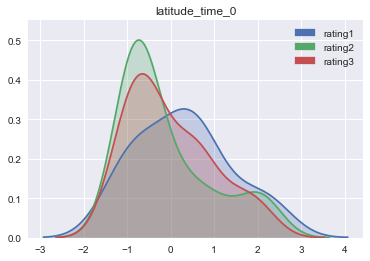

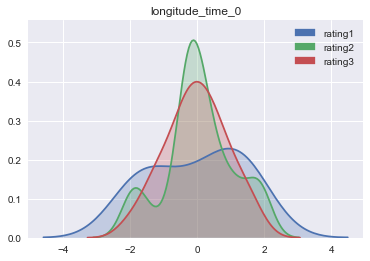

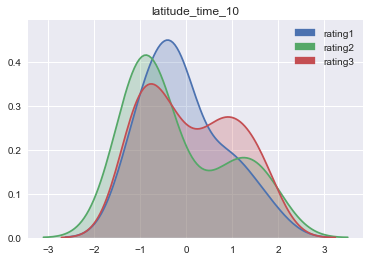

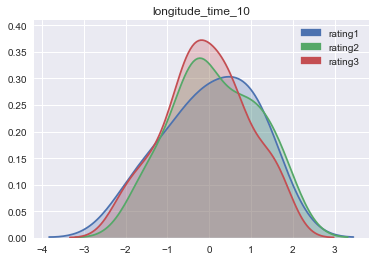

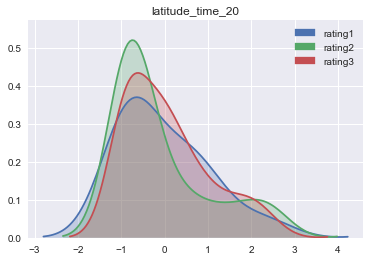

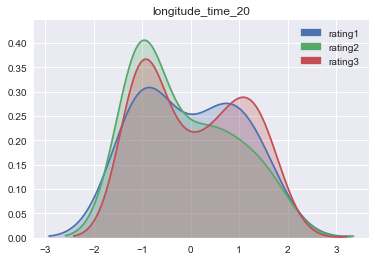

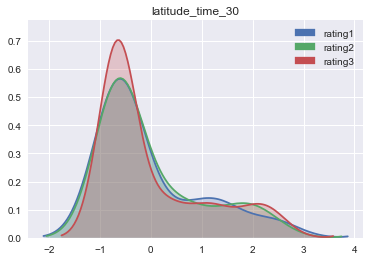

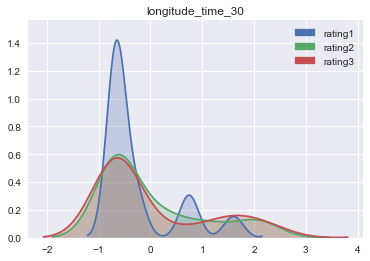

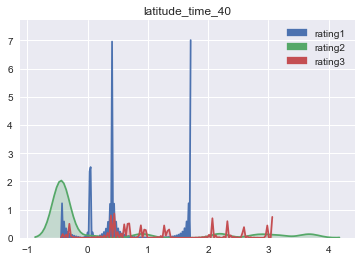

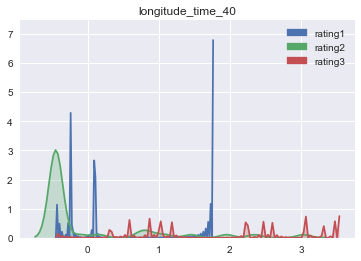

In [33]:
tp_ti10_mt40_features = list(tp_ti10_mt40.drop("rating", axis = 1).columns.values)
for feature in tp_ti10_mt40_features:
    create_density_plot_for_categorical_variable(tp_ti10_mt40, feature, "rating")

In [34]:
tp_ti10_mt40[tp_ti10_mt40["rating"]==1].describe().T

,count,mean,std,min,25%,50%,75%,max
latitude_time_0,14.0,0.296911,1.088087,-1.184898,-0.516100,0.393032,0.734658,2.332298
longitude_time_0,14.0,-0.026259,1.377494,-2.007683,-1.389007,0.070760,1.182170,1.905762
latitude_time_10,14.0,-0.066455,0.866033,-1.178105,-0.616747,-0.210480,0.425987,1.742867
longitude_time_10,14.0,0.037365,1.061487,-1.841641,-0.580134,0.147275,0.949892,1.455917
latitude_time_20,14.0,-0.024679,1.010021,-0.904999,-0.904999,-0.425609,0.480847,2.333182
longitude_time_20,14.0,-0.012389,0.994353,-1.059278,-1.059278,0.016755,0.771411,1.446423
latitude_time_30,14.0,-0.027426,1.016317,-0.656505,-0.656505,-0.656505,0.390840,2.413479
longitude_time_30,14.0,-0.241018,0.728945,-0.659657,-0.659657,-0.659657,-0.261685,1.603157
latitude_time_40,14.0,-0.193206,0.601941,-0.441789,-0.441789,-0.441789,-0.441789,1.708912
longitude_time_40,14.0,-0.233328,0.595199,-0.445700,-0.445700,-0.445700,-0.445700,1.765836


In [41]:
tp_ti10_mt40.head(10).T

,1,2,3,4,8,10,11,12,13,16
latitude_time_0,1.208211,0.818645,1.921170,-0.983626,-0.523584,-0.820741,0.515126,0.894543,-0.848517,-0.800236
longitude_time_0,-1.088521,0.213243,0.772247,0.449096,0.562514,0.432001,-1.197194,1.183736,0.997638,-0.773215
latitude_time_10,1.657466,-0.239764,-1.033903,0.459540,0.591698,-1.138467,0.803906,-0.951629,0.826604,1.836866
longitude_time_10,-1.272007,0.694667,-0.164838,1.294240,1.374914,0.395569,-2.116047,1.002519,-1.731595,-0.517656
latitude_time_20,-0.904999,-0.772551,-0.904999,0.663527,-0.904999,-0.904999,0.070830,-0.904999,0.536665,-0.452494
longitude_time_20,-1.059278,-0.718962,-1.059278,0.927529,-1.059278,-1.059278,1.365902,-1.059278,1.582041,0.866184
latitude_time_30,-0.656505,-0.656505,-0.656505,1.000765,-0.656505,-0.656505,-0.656505,-0.656505,2.312049,-0.656505
longitude_time_30,-0.659657,-0.659657,-0.659657,-0.410553,-0.659657,-0.659657,-0.659657,-0.659657,1.512414,-0.659657
latitude_time_40,-0.441789,-0.441789,-0.441789,3.063107,-0.441789,-0.441789,-0.441789,-0.441789,0.617114,-0.441789
longitude_time_40,-0.445700,-0.445700,-0.445700,0.872078,-0.445700,-0.445700,-0.445700,-0.445700,3.470258,-0.445700


In [36]:
dir = os.path.dirname(os.getcwd())
path = os.path.join(dir, "data/preprocessed_and_feature_engineered/trackspoints", "trackspoints_per_quantile_5.csv")
tp_pq4 = pd.read_csv(path, index_col="track_id")

rating = list(tp_pq4["rating"])
#indices = list(tp_pq4["track_id"])
#tp_pq4 = tp_pq4.drop(["rating","track_id"], axis = 1)


col_names = list(tp_pq4.columns.values)
for name in col_names:
    if "latitude" or "longitude" in name:
        tp_pq4[name] = (tp_pq4[name]*1000)%1
    

#tp_pq4 = pd.DataFrame(tp_pq4, columns=col_names, index = indices)
tp_pq4["rating"] = rating

In [40]:
tp_pq4.head(10).T

track_id,1,2,3,4,8,10,11,12,13,16
latitude_quantile_0,0.658614,0.560580,0.83803,0.10704,0.222809,0.14803,0.48420,0.57968,0.14104,0.15319
longitude_quantile_0,0.257890,0.571619,0.70634,0.62846,0.655794,0.62434,0.23170,0.80551,0.76066,0.33388
latitude_quantile_1,0.520097,0.653087,0.34564,0.49142,0.198866,0.14803,0.62212,0.17307,0.04711,0.29252
longitude_quantile_1,0.608625,0.253761,0.76511,0.53625,0.563110,0.62434,0.20378,0.90149,0.62788,0.25213
latitude_quantile_2,0.506547,0.053832,0.24998,0.38963,0.089976,0.14803,0.75477,0.90454,0.56547,0.66332
longitude_quantile_2,0.009373,0.610057,0.87249,0.01472,0.224905,0.62434,0.93962,0.89762,0.71538,0.71323
latitude_quantile_3,0.302568,0.358018,0.11378,0.74210,0.113746,0.07991,0.13577,0.78947,0.36351,0.14789
longitude_quantile_3,0.297019,0.715750,0.42956,0.34878,0.277761,0.64290,0.93582,0.89891,0.42812,0.73338
latitude_quantile_4,0.372368,0.133293,0.10415,0.97839,0.855431,0.07991,0.31308,0.20087,0.68718,0.33596
longitude_quantile_4,0.615785,0.001002,0.28848,0.50829,0.148510,0.64290,0.84410,0.00875,0.81317,0.20916


Again, we could not find any interesting insights by looking at the density plots for the third feature table

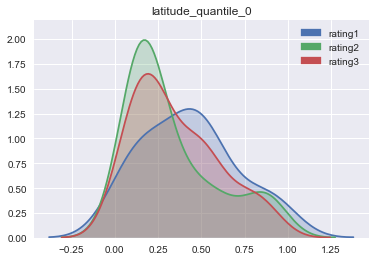

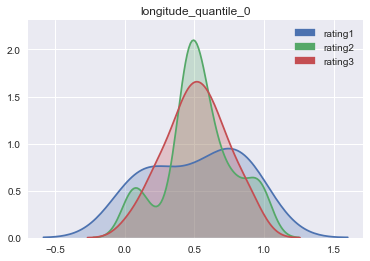

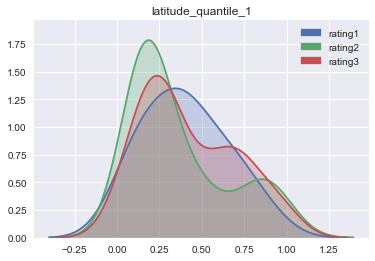

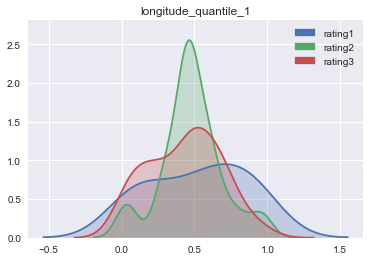

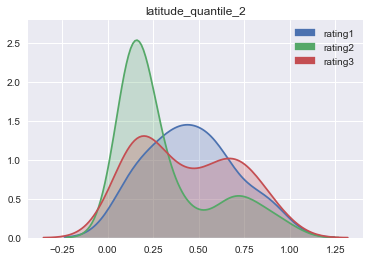

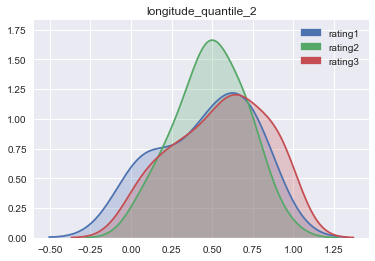

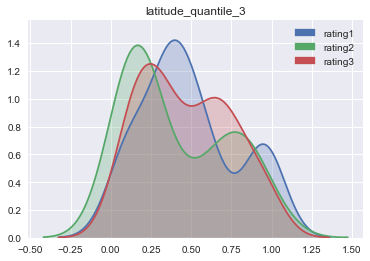

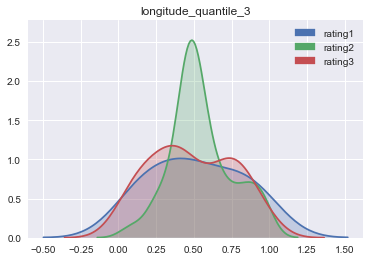

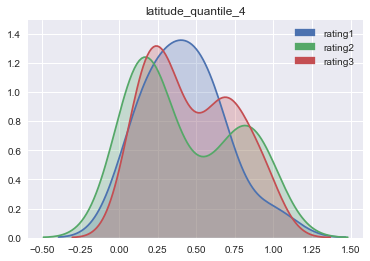

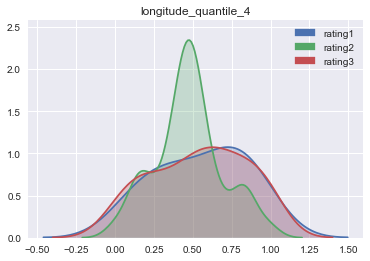

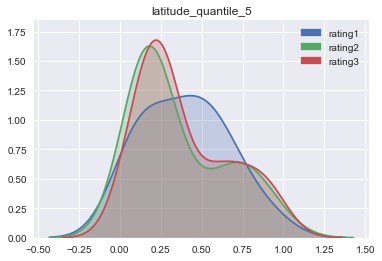

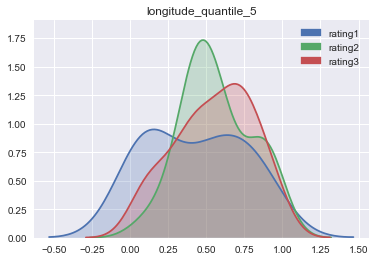

In [42]:
tp_pq4_features = list(tp_pq4.drop("rating", axis = 1).columns.values)
for feature in tp_pq4_features:
    create_density_plot_for_categorical_variable(tp_pq4, feature, "rating")